# BFast monitoring with SentinelHub

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import deque

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cmaps
import contextily as cx

from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import shape as geo_shape

from sentinelhub import SHConfig, BatchSplitter, SentinelHubRequest, BBox, CRS, WcsRequest, bbox_to_dimensions, MimeType, DataCollection, SentinelHubDownloadClient

from eolearn.core import FeatureType, EOTask, EOPatch, OverwritePermission
from eolearn.io import SentinelHubInputTask
from eolearn.features import NormalizedDifferenceIndexTask
from eolearn.geometry import FelzenszwalbSegmentation, RasterToVector
import datetime

from scipy import ndimage, stats

In [34]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

### Define Area of Interest

In [4]:
# in this example we focus to forest in Brazil 
aoi = BBox([-61.58,-7.62,-61.48,-7.52], crs=CRS.WGS84)

In [5]:
NE = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

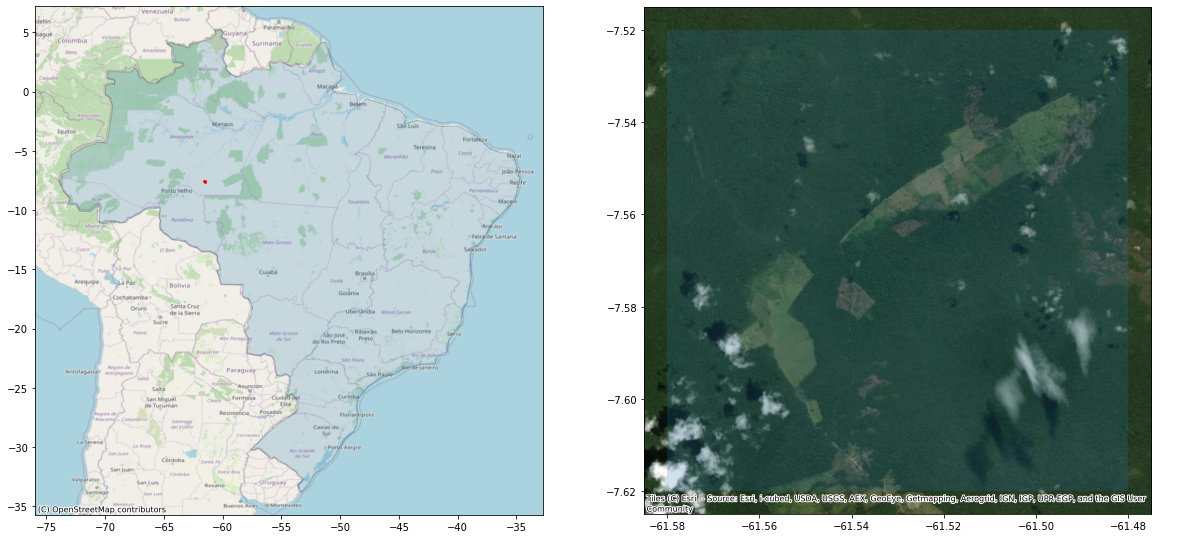

In [6]:
fig,ax = plt.subplots(ncols=2, figsize=(20,13), gridspec_kw={'width_ratios': [1,1]})
NE[NE.name=='Brazil'].plot(ax=ax[0], alpha=0.2, color=None, edgecolor='k', linewidth = 1)
cx.add_basemap(ax[0], crs=CRS.WGS84.epsg, source=cx.providers.OpenStreetMap.Mapnik)
gpd.GeoDataFrame(geometry=[aoi.geometry], crs=CRS.WGS84.pyproj_crs()).plot(ax=ax[0], alpha=1, color='red', edgecolor='r', linewidth=3)
gpd.GeoDataFrame(geometry=[aoi.geometry], crs=CRS.WGS84.pyproj_crs()).plot(ax=ax[1], alpha=0.2)
cx.add_basemap(ax[1], crs=CRS.WGS84.epsg, source=cx.providers.Esri.WorldImagery)

### Collecting S-2 data

In [35]:
config = SHConfig()

In [36]:
# add your instance, client id and secret here, if needed
config.instance_id = ""
config.sh_client_id = ""
config.sh_client_secret = ""

In [10]:
bands = ['B04','B08']

In [11]:
class StandardizedNDVI(EOTask):
    def execute(self, eopatch):
        eopatch.data['NDVI_STANDARDIZED'] = stats.zscore(eopatch.data['NDVI'], axis=(1, 2, 3), nan_policy='omit')
        return eopatch

In [12]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=bands,
    bands_feature=(FeatureType.DATA, 'L1C_data'),
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM')],
    resolution=(10,10),
    maxcc=1,
    time_difference=datetime.timedelta(hours=2),
    config=config,
    max_threads=5
)

ndvi_task = NormalizedDifferenceIndexTask((FeatureType.DATA, 'L1C_data'), (FeatureType.DATA, 'NDVI'),
                                          [bands.index('B08'), bands.index('B04')], acorvi_constant=0.001)


standardize_ndvi = StandardizedNDVI()

superpixel_task = FelzenszwalbSegmentation((FeatureType.DATA, 'NDVI_STANDARDIZED'), 
                                           (FeatureType.MASK_TIMELESS, 'SUPER_PIXELS'), 
                                           scale=1, sigma=0, min_size=100)

ras2vec = RasterToVector(features=(FeatureType.MASK_TIMELESS, 'SUPER_PIXELS', 'SUPER_PIXELS'))

In [13]:
# beware, such EOPatch will be very large (in terms of memory/disk)

eopatch = input_task.execute(bbox=aoi, time_interval=('2017-01-01','2020-11-11')) 

In [37]:
# execute needed tasks to get to segmented pixels

eopatch = ndvi_task.execute(eopatch)
eopatch = standardize_ndvi.execute(eopatch)

#free some memory
del eopatch.data['NDVI']
del eopatch.data['L1C_data']

eopatch = superpixel_task.execute(eopatch)
eopatch.mask_timeless['SUPER_PIXELS'] = eopatch.mask_timeless['SUPER_PIXELS'].astype(np.int32)
eopatch = ras2vec.execute(eopatch)
    

In [38]:
# store the eopatch at the end / or any time in between :)

# eopatch.save('/home/eolearner/EOP')

### Check results of segmentation

<AxesSubplot:>

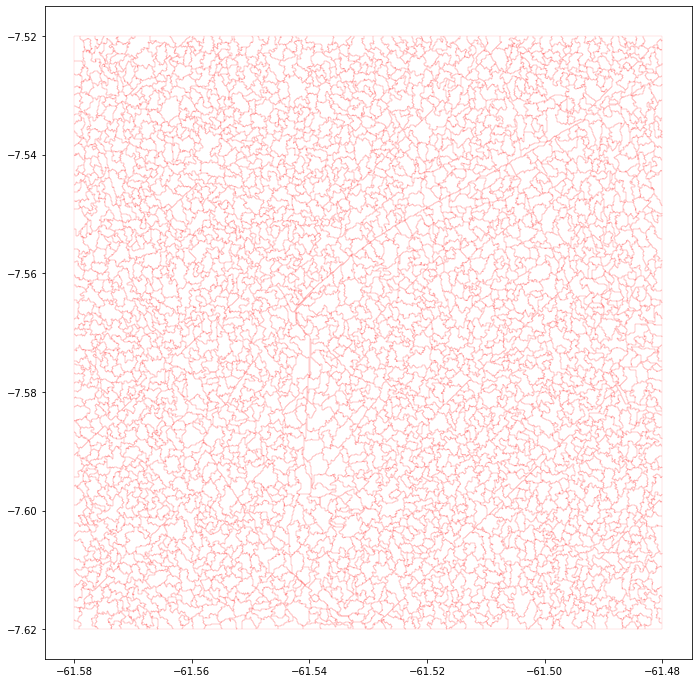

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
eopatch.vector_timeless['SUPER_PIXELS'].geometry.boundary.plot(ax=ax, color=None, edgecolor='r', linewidth=0.1)

### Prepare data for BFast

In [39]:
n_superpixels = np.unique(eopatch.mask_timeless['SUPER_PIXELS']).size

In [18]:
superpixels = eopatch.mask_timeless['SUPER_PIXELS']

In [19]:
n_timestamps = len(eopatch.timestamp)

In [20]:
temporal_superpixels = np.array([idx*n_superpixels + superpixels for idx in range(n_timestamps)])

In [21]:
mean_clm_superpixels = ndimage.mean(eopatch.mask['CLM'], labels=temporal_superpixels, index=np.unique(temporal_superpixels)).reshape((n_timestamps, n_superpixels))

In [22]:
mean_ndvi_superpixels = ndimage.mean(eopatch.data['NDVI_STANDARDIZED'], labels=temporal_superpixels, index=np.unique(temporal_superpixels)).reshape((n_timestamps, n_superpixels))

In [23]:
valid_data = np.where(mean_clm_superpixels<0.2, mean_ndvi_superpixels, np.nan)

In [24]:
dates = np.array([date.strftime('%Y-%m-%d') for date in eopatch.timestamp])

### Run BFast 

In [25]:
def run_bfast(ndvi_seq, dates, monitor_start=(2020, 1)):
    """
    This is where R package comes in. We have a sequence ov ndvi values through time in `ndvi_seq`
    and we have list of dates in `self.dates`
    """
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    import rpy2.robjects.numpy2ri as rpyn
    
    importr('bfast')
    r_apply = ro.r('apply')

    ndates, npixels = ndvi_seq.shape

    r_ndvi = rpyn.numpy2ri(ndvi_seq)
    r_dates = ro.StrVector(dates)

    r_bfastmonitor = ro.r('function(x, dates){\n'
                          'ndvi <- bfastts(x, dates, type = c("irregular"))\n'
                          'bfm <- bfastmonitor(ndvi, start=c(' + str(monitor_start[0]) + ', ' +
                          str(monitor_start[1]) + '), history="all")\n'
                          # 'plot(bfm)\n'  # debug: drawing R plots
                          'return(cbind(bfm$breakpoint, bfm$magnitude, bfm$tspp$prediction))\n'
                          '}')

    r_results = r_apply(r_ndvi, ro.IntVector([2]), r_bfastmonitor, r_dates)
    breakpoints, magnitude, prediction = np.zeros((npixels,), dtype=np.float32), np.zeros((npixels,),
                                                                                          dtype=np.float32), []
    for npix in range(npixels):
        bfm_values = np.array(r_results.__getitem__(npix))  # (n_valid_dates, 3)
        breakpoints[npix] = bfm_values[0, 0]
        magnitude[npix] = bfm_values[0, 1]
        prediction.append(bfm_values[:, 2].ravel())

    return breakpoints, magnitude, prediction

In [26]:
def to_date(breakpoint):
    if np.isnan(breakpoint):
        return np.datetime64("NaT")
    year = int(breakpoint)
    return datetime.date(year, 1, 1) + datetime.timedelta(days=356 * (breakpoint % year))

In [27]:
monitor_start_date = (2020,4)

In [28]:
sp_breakpoints, sp_magnitudes, sp_prediction = run_bfast(valid_data, dates, monitor_start_date)

### Organize results (add to vectorized "super pixels")

In [40]:
super_pixels_df = eopatch.vector_timeless['SUPER_PIXELS']

output_df = pd.DataFrame({
    'VALUE':range(0,n_superpixels), 
    'breakpoint': [to_date(b) for b in sp_breakpoints],
    'magnitude': sp_magnitudes
})

In [30]:
results = super_pixels_df.merge(output_df, on='VALUE')

In [31]:
results.head()

,VALUE,geometry,breakpoint,magnitude
0,9.0,"POLYGON ((-61.55977 -7.52000, -61.55796 -7.520...",2020-02-09,0.030134
1,48.0,"POLYGON ((-61.49310 -7.52000, -61.49147 -7.520...",NaT,0.023147
2,14.0,"POLYGON ((-61.55001 -7.52109, -61.54992 -7.521...",NaT,-0.010604
3,14.0,"POLYGON ((-61.55281 -7.52000, -61.54983 -7.520...",NaT,-0.010604
4,16.0,"POLYGON ((-61.54874 -7.52000, -61.54694 -7.520...",NaT,0.004246


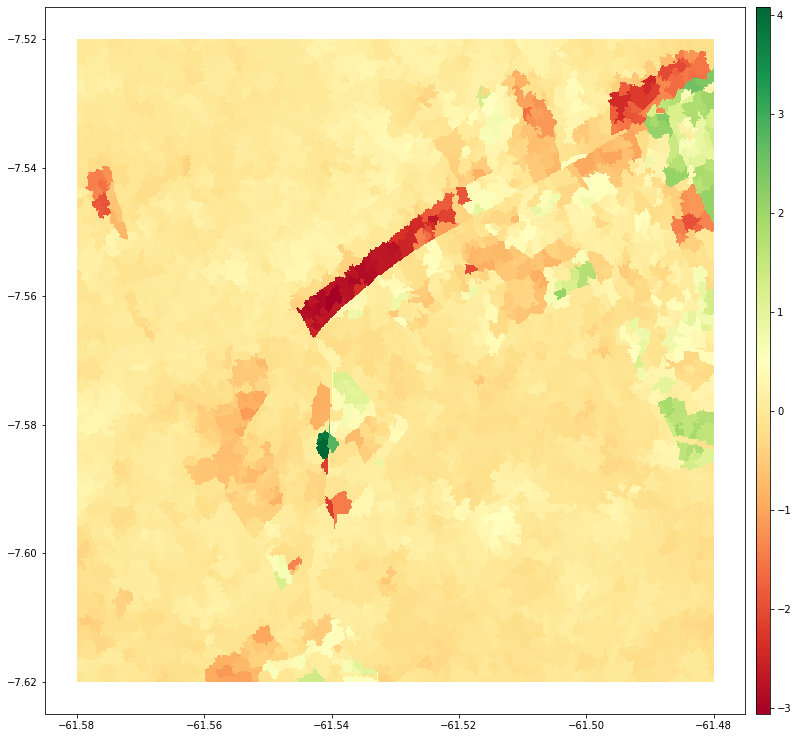

In [41]:
fig, ax = plt.subplots(figsize=(15,13))
divider = make_axes_locatable(ax)
cax = make_axes_locatable(ax).append_axes('right', size='2%', pad=0.1)
cbar = results.plot(ax=ax, column='magnitude', cmap=cmaps.RdYlGn, legend=True, cax=cax)

In [42]:
by_breakpoints = results.groupby(by='breakpoint', as_index=False).agg({'VALUE': 'count', 'magnitude': ['min', 'max']})#.query('(magnitude > 3) or (magnitude < -3)')
by_breakpoints.columns = [f"{x}_{y}" if y else x for x, y in by_breakpoints.columns.to_flat_index()]

In [43]:
by_breakpoints.query('(magnitude_max > 3) or (magnitude_min < -3)')

,breakpoint,VALUE_count,magnitude_min,magnitude_max
7,2020-03-22,89,-3.038306,0.333422
14,2020-06-04,40,-2.798667,3.808013
15,2020-06-08,35,-3.028984,1.055913
16,2020-06-13,48,-3.055240,0.832247
18,2020-06-23,68,-2.473472,4.082850


There seems to be a lot happening in June 2020. Let's have a look.

### Let's see changes in colors

In [47]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        let gain = 3.5;
        return [sample.B04, sample.B03, sample.B04].map(a => gain * a);
    }
"""

def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=aoi,
        size=bbox_to_dimensions(aoi, 60),
        config=config
    )

In [48]:
before_june = get_true_color_request((datetime.datetime(2020,1,1), datetime.datetime(2020,6,1))).get_data()
after_june = get_true_color_request((datetime.datetime(2020,7,1), datetime.datetime(2020,9,1))).get_data()

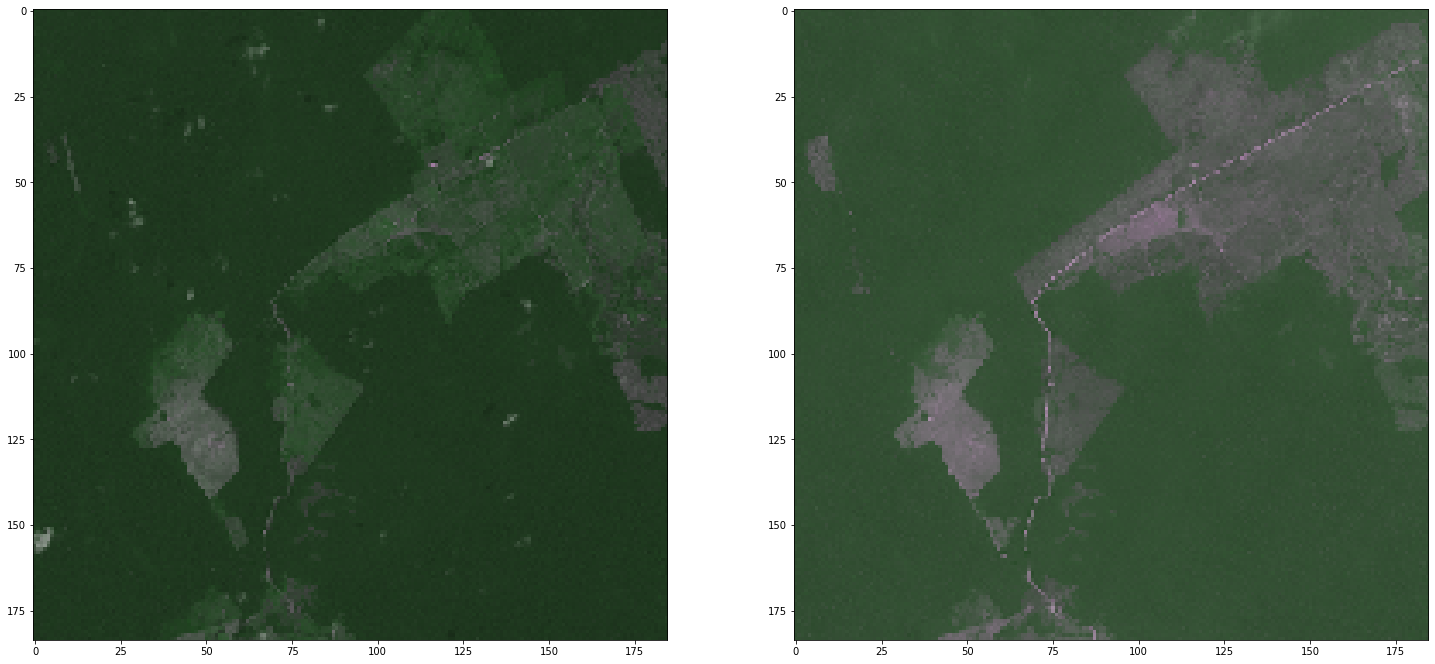

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(25,12))
ax[0].imshow(before_june[0])
ax[1].imshow(after_june[0])

The images clearly show change. If one looks to the image on the right, there are still some smoke plumes visible, (top right of the picture on the right), pointing to changes being detected probably due to burning agricultural practices.

Let's look at all the images in the monitoring period (Jan 1, 2020 onwards)

In [50]:
start = datetime.date(2020,1,1)
end = datetime.date(2020, 11, 11)

x = start
slots = []
while x < end:
    y = x+datetime.timedelta(weeks=4)
    slots.append((x, y))
    x = y

In [51]:
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

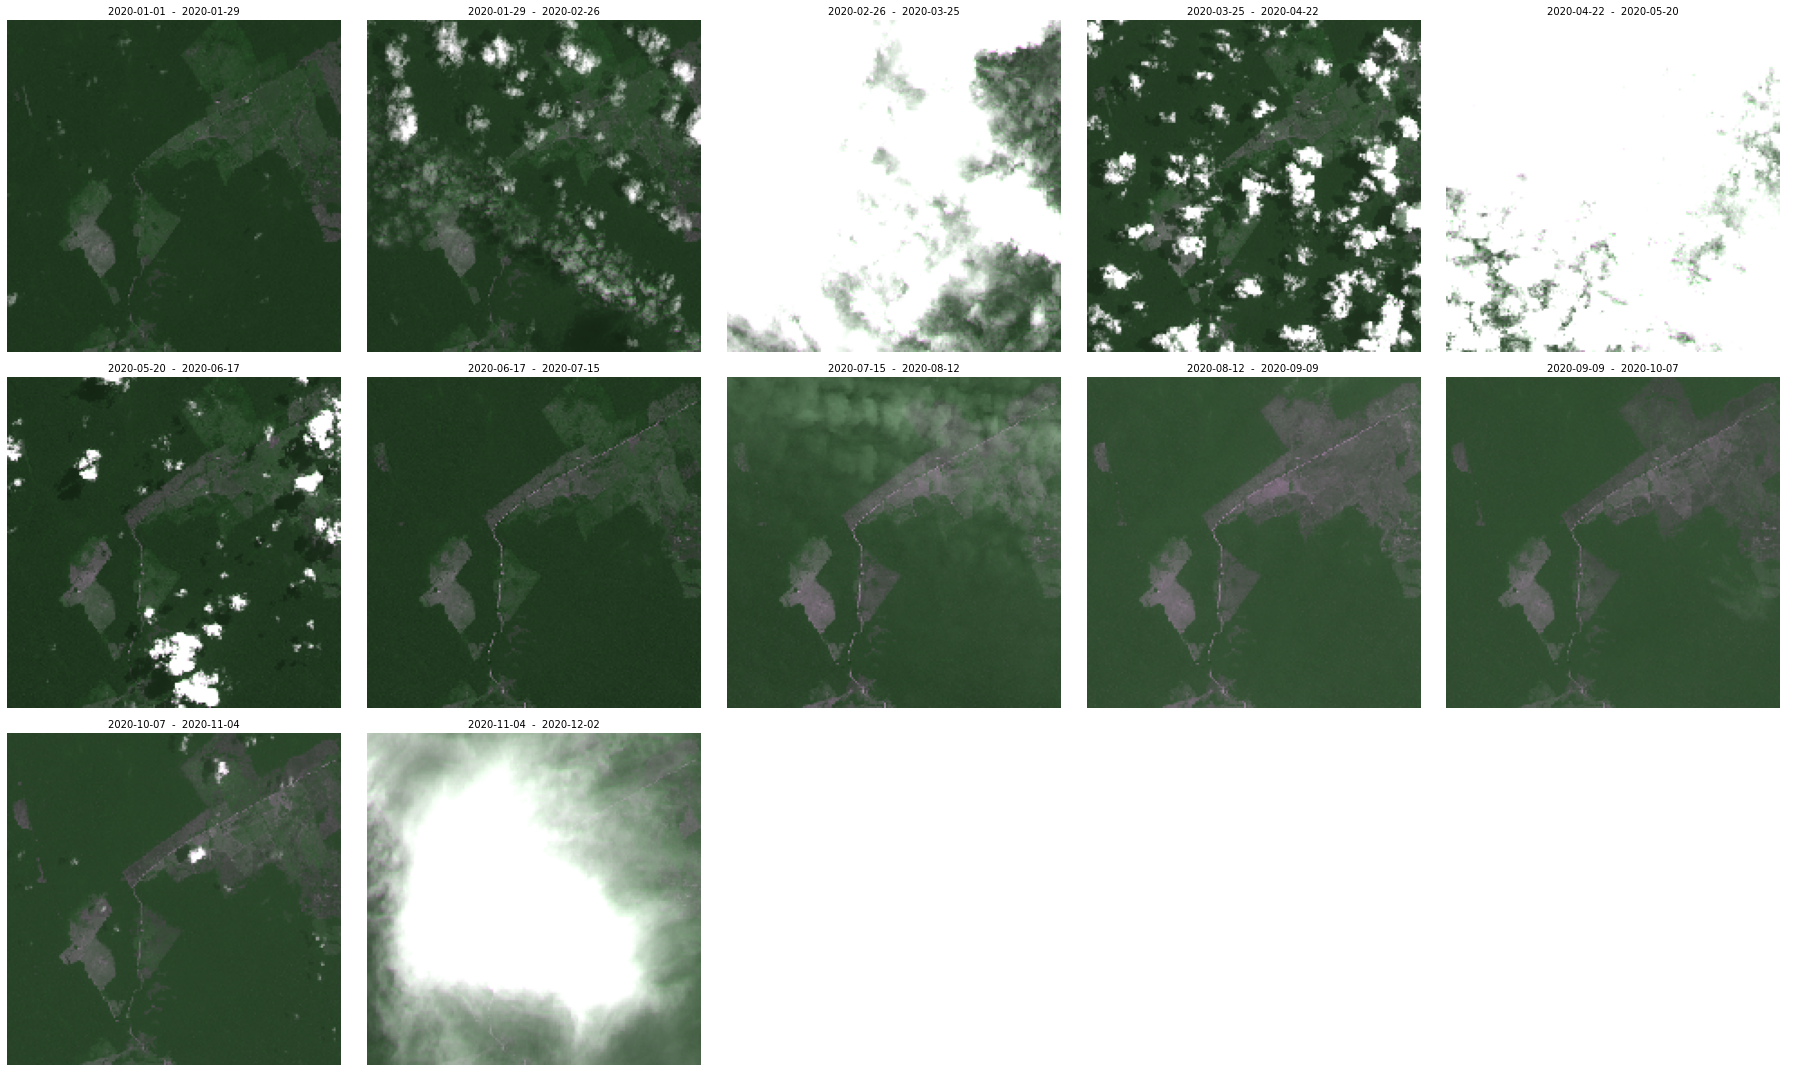

In [53]:
ncols = 5
nrows = int(len(slots)/ncols)+1
aspect_ratio = bbox_to_dimensions(aoi, 60)[0] / bbox_to_dimensions(aoi, 60)[1]
subplot_kw = {'xticks': [], 'yticks': [], 'frame_on': False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows),
                        subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(image)
    ax.set_title(f'{slots[idx][0]}  -  {slots[idx][1]}', fontsize=10)

plt.tight_layout()